# Setup

In [ ]:
# Import libraries

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import shutil
!pip install split-folders
import splitfolders
from PIL import Image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [ ]:
# Random seed for reproducibility

seed = 37

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Ignore warnings

import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Loading Data

In [ ]:
# Dataset folders

dataset_in = "../input/challenge1/training_data_final_cmpl"
dataset_dir = "/kaggle/working/dataset"
data_dir = '/kaggle/working/data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Function to resize images from original size to 224x224

def resize_image_in_path(in_path, out_path, size):
    image_to_resize = []
    os.makedirs(out_path)
    for folder in os.listdir(in_path):
        os.makedirs(os.path.join(out_path, folder))
        for filename in os.listdir(os.path.join(in_path, folder)):
            image = Image.open(os.path.join(in_path, folder, filename))
            new_image = image.resize((size, size))
            new_image.save(out_path + "/" + folder + "/" + filename)
        
resize_image_in_path(dataset_in, dataset_dir, 224)

In [ ]:
# Function to split the dataset into training and validation folders

splitfolders.ratio(dataset_dir, 
                   output=data_dir, 
                   seed=seed,
                   ratio=(.9, .1), 
                   move=False, 
                   group_prefix=None)

Copying files: 3542 files [00:00, 7856.23 files/s]


In [ ]:
# Function to perform oversampling of images of species 1 and species 6, in order to balance the amount of images for each species

def multiply_file_in_path(path, multiply_factor):
    file_to_multiply = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            file_to_multiply.append(filename)
        
    for filepath in file_to_multiply:
        for i in range(multiply_factor):
            shutil.copy(os.path.join(path, filepath), os.path.join(path, "copia" + str(i) + "-" + filepath))
        
path = '/kaggle/working/data/train/Species1'
multiply_factor = 2
multiply_file_in_path(path, multiply_factor)

path = '/kaggle/working/data/train/Species6'
multiply_factor = 1
multiply_file_in_path(path, multiply_factor)

In [ ]:
# Define parameters

batch_size = 64
img_height = 224
img_width = 224

# Load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 3716 files belonging to 8 classes.
Found 359 files belonging to 8 classes.


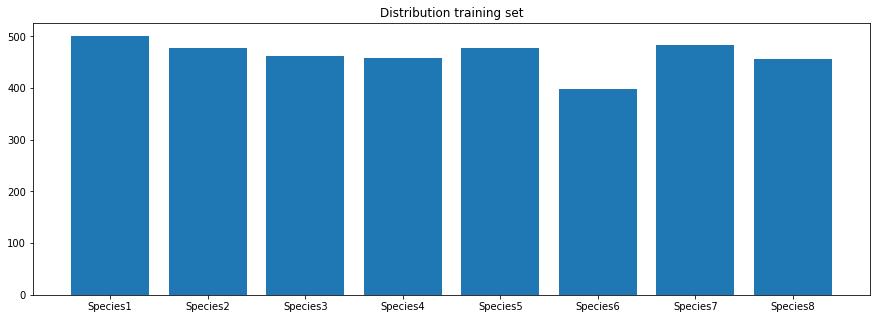

In [ ]:
# Plot of the distribution of training set, after oversampling

height = np.zeros(len(train_ds.class_names))
for images_batch, labels_batch in train_ds:
    for labels in labels_batch:
        height[labels] += 1

plt.figure(figsize=(15,5))
plt.title('Distribution training set')
plt.bar(train_ds.class_names, height)
plt.show()

# Data Augmentation

In [ ]:
# Perform data augmentation: rotations, translations and flips

data_augmentation = tf.keras.Sequential([
  tfkl.RandomRotation([-0.4, 0.4], fill_mode="reflect"),
  tfkl.RandomTranslation(height_factor=0.3, width_factor=0.3, fill_mode="reflect"),
  tfkl.RandomFlip("horizontal_and_vertical"),
])

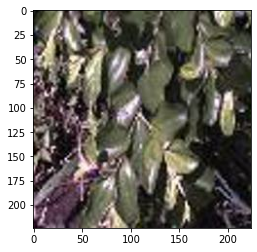

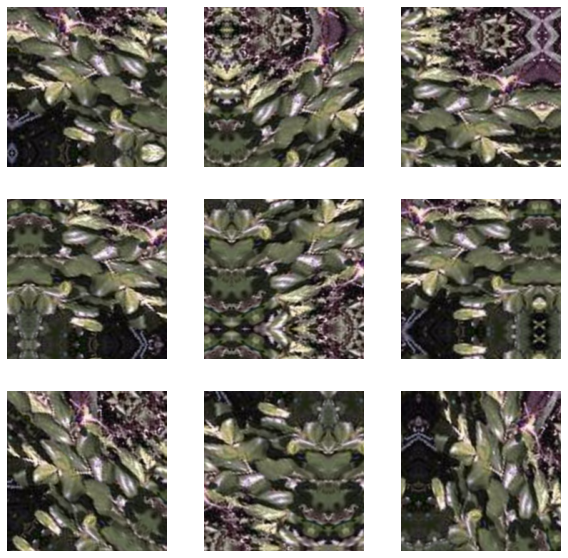

In [ ]:
# Code to plot one original image from training set, that is augmented 9 times (in order to tune augmentation parameters)

image = []
for images, labels in train_ds.take(1):
  image = images[0]
plt.imshow(image.numpy().astype("uint8"))

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis("off")

# CNN Model

In [ ]:
# Include DenseNet201 as supernet, without top layers

input_shape = (224, 224, 3)
epochs = 500

supernet = tfk.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
# Define the model. Dropout of 0.5 is applied to the first two hidden layers as regularizer

def build_model(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    preprocessing_layer = tfkl.Lambda(lambda x: preprocess_input(x))(input_layer)

    dense_net = supernet(preprocessing_layer)

    GAP_layer = tfkl.GlobalAveragePooling2D(name='GAP')(dense_net)

    dense_layer_1 = tfkl.Dense(units=256, activation='relu', kernel_initializer = tfk.initializers.GlorotUniform(seed))(GAP_layer)
    
    dropout_1 = tfkl.Dropout(0.5, seed=seed)(dense_layer_1)

    dense_layer_2 = tfkl.Dense(units=256, activation='relu', kernel_initializer = tfk.initializers.GlorotUniform(seed))(dropout_1)
    
    dropout_2 = tfkl.Dropout(0.5, seed=seed)(dense_layer_2)
    
    dense_layer_3 = tfkl.Dense(units=256, activation='relu', kernel_initializer = tfk.initializers.GlorotUniform(seed))(dropout_2)
    
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dense_layer_3)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

    # Return the model
    return model

# Transfer Learning Model - Training

In [ ]:
# Build the model, set DenseNet as non-trainable and get the summary of the built model

model = build_model(input_shape)
model.get_layer("densenet201").trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792 

In [ ]:
# Train lambda function maps each image to an augmented version of the image and its label to its one hot encoding
# Validation lambda function maps each image to itself and its label to its one hot encoding

train_ds_pre = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), tf.one_hot(y, depth=8)))
val_ds_pre = val_ds.map(
  lambda x, y: (x, tf.one_hot(y, depth=8)))

# Fit the model to perform transfer learning, using EarlyStopping and ReduceLROnPlateau as callbacks

history = model.fit(
    x = train_ds_pre,
    epochs = epochs,
    validation_data = val_ds_pre,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5)]
).history

Epoch 1/500
59/59 [==============================] - 111s 1s/step - loss: 2.0142 - accuracy: 0.2217 - val_loss: 1.7782 - val_accuracy: 0.3565
Epoch 2/500
59/59 [==============================] - 79s 1s/step - loss: 1.4798 - accuracy: 0.4429 - val_loss: 1.4268 - val_accuracy: 0.5460
Epoch 3/500
59/59 [==============================] - 79s 1s/step - loss: 1.0584 - accuracy: 0.6171 - val_loss: 0.7521 - val_accuracy: 0.7298
Epoch 4/500
59/59 [==============================] - 79s 1s/step - loss: 0.7965 - accuracy: 0.7263 - val_loss: 0.6293 - val_accuracy: 0.7716
Epoch 5/500
59/59 [==============================] - 79s 1s/step - loss: 0.7038 - accuracy: 0.7616 - val_loss: 0.5615 - val_accuracy: 0.8301
Epoch 6/500
59/59 [==============================] - 79s 1s/step - loss: 0.5618 - accuracy: 0.8081 - val_loss: 0.5806 - val_accuracy: 0.8134
Epoch 7/500
59/59 [==============================] - 79s 1s/step - loss: 0.5115 - accuracy: 0.8321 - val_loss: 0.5107 - val_accuracy: 0.8440
Epoch 8/500


# Visualization of the results - Transfer Learning

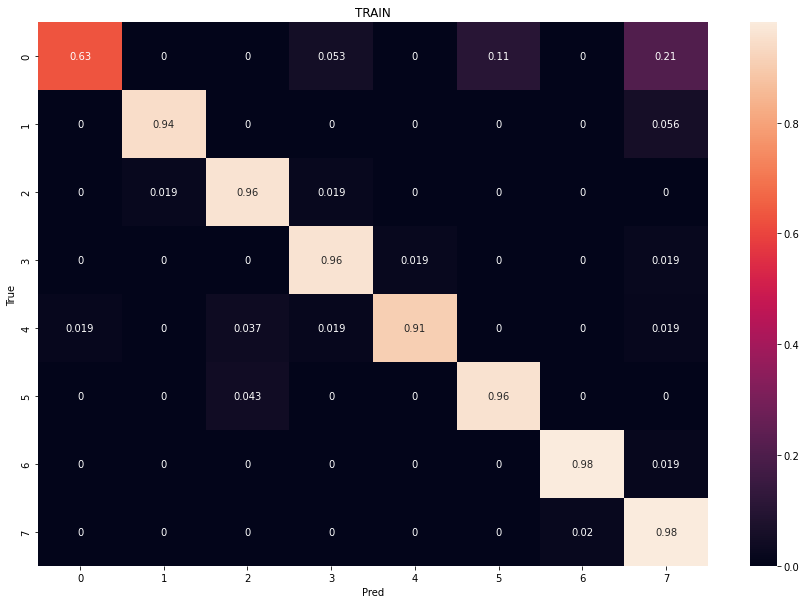

In [ ]:
# Plot the confusion matrix of the model after transfer learning

from sklearn.metrics import confusion_matrix

def plot_result(model, dataset):
  y_pred = model.predict(dataset)
  y_pred = tf.argmax(y_pred, axis=-1)
  y_true = []

  for images_batch, labels_batch in dataset:
    for label in labels_batch:
        y_true.append(label.numpy())
  y_true = tf.argmax(y_true, axis=-1)

  bm_cfm = confusion_matrix(y_true, y_pred, normalize="true")
  plt.figure(figsize=(15,10))
  sns.heatmap(bm_cfm, annot=bm_cfm)
  plt.title("TRAIN")
  plt.xlabel("Pred")
  plt.ylabel("True")
  plt.show()

plot_result(model, val_ds_pre)

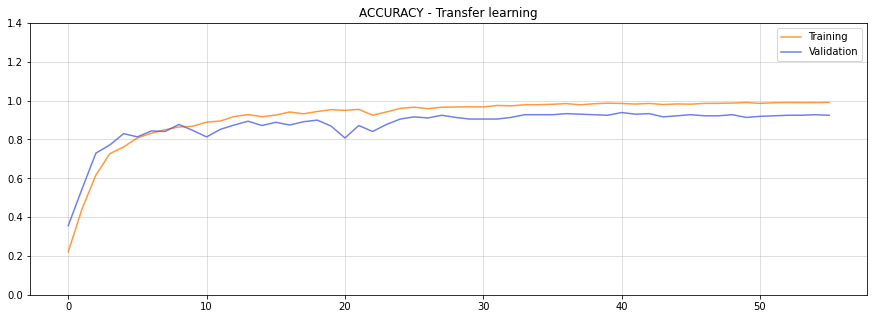

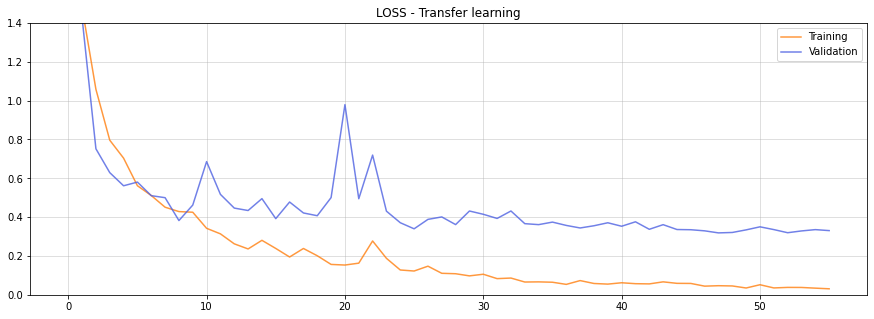

In [ ]:
# Plot the training and validation accuracy of the model after transfer learning

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1.4)
plt.title('ACCURACY - Transfer learning')
plt.legend(loc='upper right')
plt.grid(alpha=.5)
plt.show()

# Plot the training and validation loss of the model after transfer learning

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1.4)
plt.title('LOSS - Transfer learning')
plt.legend(loc='upper right')
plt.grid(alpha=.5)
plt.show()

In [ ]:
# Save transfer learning model

model_directory_name = '/kaggle/working/Model/model_TL'
model.save(model_directory_name)

# Fine Tuning Model - Training

In [ ]:
# Set DenseNet as trainable, in order to fine tune the model

model.get_layer("densenet201").trainable = True
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792 

In [ ]:
# Fit the model to perform fine tuning, using EarlyStopping and ReduceLROnPlateau as callbacks

history = model.fit(
    x = train_ds_pre,
    epochs = epochs,
    validation_data = val_ds_pre,
    class_weight = {0:2., # set the weight of species 1 equal to 2, since after transfer learning confusion matrix highlighted a low accuracy on that class
                    1:1.,
                    2:1.,
                    3:1.,
                    4:1.,
                    5:1.,
                    6:1.,
                    7:1},
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)]
).history

Epoch 1/500
59/59 [==============================] - 82s 1s/step - loss: 0.1141 - accuracy: 0.9691 - val_loss: 0.6184 - val_accuracy: 0.8858
Epoch 2/500
59/59 [==============================] - 59s 993ms/step - loss: 0.1612 - accuracy: 0.9513 - val_loss: 0.5608 - val_accuracy: 0.8802
Epoch 3/500
59/59 [==============================] - 60s 1s/step - loss: 0.1452 - accuracy: 0.9604 - val_loss: 0.4390 - val_accuracy: 0.9081
Epoch 4/500
59/59 [==============================] - 60s 1s/step - loss: 0.1300 - accuracy: 0.9661 - val_loss: 0.3432 - val_accuracy: 0.9192
Epoch 5/500
59/59 [==============================] - 60s 1s/step - loss: 0.1391 - accuracy: 0.9618 - val_loss: 0.3875 - val_accuracy: 0.9136
Epoch 6/500
59/59 [==============================] - 60s 1s/step - loss: 0.0877 - accuracy: 0.9747 - val_loss: 0.4240 - val_accuracy: 0.9109
Epoch 7/500
59/59 [==============================] - 60s 1s/step - loss: 0.0993 - accuracy: 0.9742 - val_loss: 0.4787 - val_accuracy: 0.9025
Epoch 8/50

# Visualization of the results - Fine Tuning

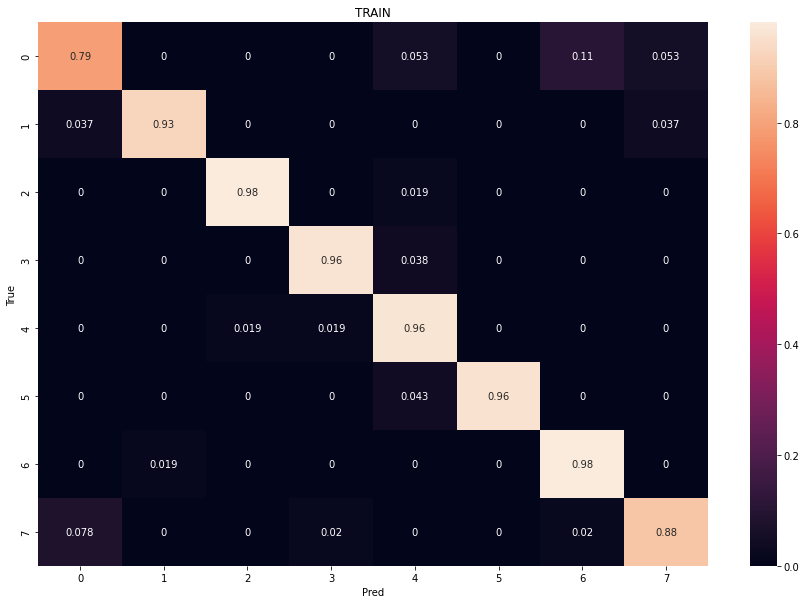

In [ ]:
# Plot the confusion matrix of the model after fine tuning

plot_result(model, val_ds_pre)

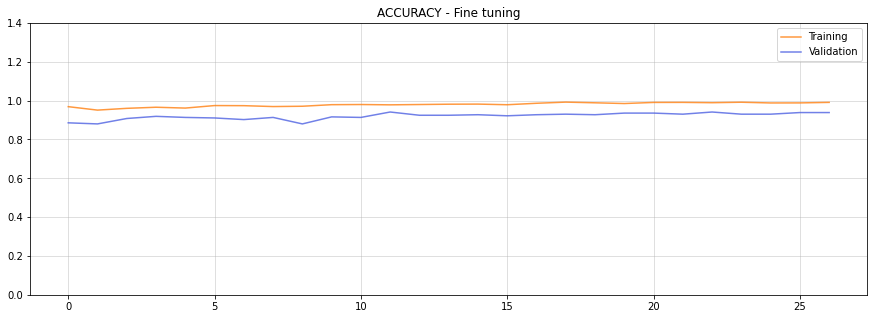

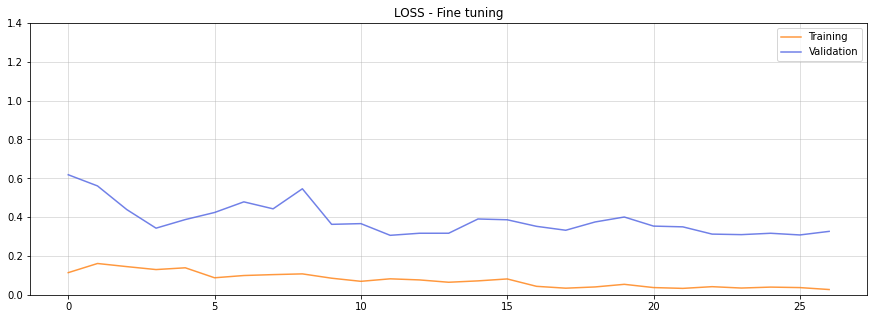

In [ ]:
# Plot the training and validation accuracy of the model after fine tuning

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1.4)
plt.title('ACCURACY - Fine tuning')
plt.legend(loc='upper right')
plt.grid(alpha=.5)
plt.show()

# Plot the training and validation loss of the model after fine tuning

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1.4)
plt.title('LOSS - Fine tuning')
plt.legend(loc='upper right')
plt.grid(alpha=.5)
plt.show()

In [ ]:
# Save fine tuning model

model_directory_name = '/kaggle/working/Model/model_FT'
model.save(model_directory_name)

In [ ]:
shutil.make_archive("MODELLO_FINALE", 'zip', "/kaggle/working/Model/model_FT")

'/kaggle/working/MODELLO_FINALE.zip'